# Progetto architettura dati

Si vuoule leggere un dataset di applicazioni android, ogni aplicazione è etichettata come "goodware" o "malware" e le feature del dataset sono i permessi richiesti nel manifest dell'applicazione / alcune api call fatte dall'app.

Si vogliono sviluppare i seguenti 2 punti:
1. dimostrare che è possibile predirre correttamente se un applicazione è un malware o goodware in base ai permessi e le api call

In [913]:
# import delle librerie necessarie
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans Nabataean, Nimbus Sans, Nimbus Roman'

from sklearn.model_selection import train_test_split

# logistic regression model
from sklearn.linear_model import LogisticRegression

# RFECV
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV

# evaluation metric
from sklearn.metrics import matthews_corrcoef, make_scorer


## Caricare il dataset

Si parte da un dataset con le seguenti feature:
- colonna 1->214: Permission-based features -> sono tutte feature binarie 0=permesso non richiesto, 1=permesso richiesto
- colonna 215->241: API based features -> sono tutte feature binarie 0=api call non richiesta, 1=api call richiesta
- colonna 242: label (target), dove le classi sono:
    - Malware 
    - Goodware

In [914]:
# Lettura del dataset
dataset = pd.read_csv('Dataset/TUANDROMD.csv')

In [915]:
# Mi salvo target e features in variabili diverse
uni_target = dataset[['Label']]
uni_feature = dataset.drop(['Label'], axis=1)

print(uni_target)

         Label
0      malware
1      malware
2      malware
3      malware
4      malware
...        ...
4460  goodware
4461  goodware
4462  goodware
4463  goodware
4464  goodware

[4465 rows x 1 columns]


## Data Exploration
Come primo step controlliamo la numerosità del dataset.

In [916]:
# Mi salvo in una variabile il numero di features per dopo
n_features0 = dataset.shape[1] - 1

# Stampo il numero di records e di features
print(f'Ci sono {dataset.shape[0]} istanze ed un totale di {n_features0} features!')

Ci sono 4465 istanze ed un totale di 241 features!


### Dataset sbilanciato?

Il dataset è sbilanciato? proviamo a fare un **analisi univariata** sui valori di Label per verificare:

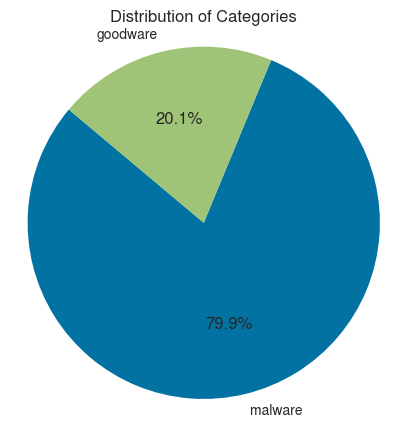

In [917]:
# Conta le occorrenze per ogni valore di Label
label_counts = uni_target['Label'].value_counts()

# Visualizzali in un piechart
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')
plt.axis('equal')
plt.show()

Per quanto possa non piacerci molto la notizia che il dataset sia sbilanciato (può comportare degli errori bias nella classificazione dei modelli) abbiamo però la buona notizia della sicurezza che il data-set sia binario. 

Sarà quindi necessario utilizzare modelli che offrono buone prestazioni su dataset binari e non troppo suscettibili a dataset sbilanciati. Inoltre **poiché questo set di dati è fortemente sbilanciato, non dobbiamo utilizzare l'accuratezza come parametro di valutazione**, sarebbe meglio invece usare l'F1-score

### Valori mancanti?
Controlliamo ora se il dataset contiene valori mancanti

In [918]:
null_count_features = np.count_nonzero(uni_feature.isna().sum())
print(f"in totale ci sono {null_count_features}/241 features con valori mancanti")

in totale ci sono 241/241 features con valori mancanti


sembra che **tutte** le features contengano almeno un valore nullo.

sviluppiamo quindi una funzione che ci andrà ad elencare tutte le features con valori mancanti in ordine decrescente:

In [919]:
def conteggio_valori_nulli_per_colonna(df):
    colonne_con_valori_nulli = df.columns[df.isnull().any()]
    conteggio_valori_nulli = [(colonna, df[colonna].isnull().sum()) for colonna in colonne_con_valori_nulli]
    conteggio_valori_nulli_sorted = sorted(conteggio_valori_nulli, key=lambda x: x[1], reverse=True)
    
    for colonna, num_valori_nulli in conteggio_valori_nulli_sorted:
        print(f"Colonna '{colonna}': {num_valori_nulli} valori nulli")
        if num_valori_nulli > 0:
            print("Record con valori nulli:")
            records_con_null = df[df[colonna].isnull()]
            for index, row in records_con_null.iterrows():
                print(f"Indice: {index}, Valori: {row.to_dict()}")

In [920]:
print(conteggio_valori_nulli_per_colonna(dataset))

Colonna 'ACCESS_ALL_DOWNLOADS': 1 valori nulli
Record con valori nulli:
Indice: 2533, Valori: {'ACCESS_ALL_DOWNLOADS': nan, 'ACCESS_CACHE_FILESYSTEM': nan, 'ACCESS_CHECKIN_PROPERTIES': nan, 'ACCESS_COARSE_LOCATION': nan, 'ACCESS_COARSE_UPDATES': nan, 'ACCESS_FINE_LOCATION': nan, 'ACCESS_LOCATION_EXTRA_COMMANDS': nan, 'ACCESS_MOCK_LOCATION': nan, 'ACCESS_MTK_MMHW': nan, 'ACCESS_NETWORK_STATE': nan, 'ACCESS_PROVIDER': nan, 'ACCESS_SERVICE': nan, 'ACCESS_SHARED_DATA': nan, 'ACCESS_SUPERUSER': nan, 'ACCESS_SURFACE_FLINGER': nan, 'ACCESS_WIFI_STATE': nan, 'activityCalled': nan, 'ACTIVITY_RECOGNITION': nan, 'ACCOUNT_MANAGER': nan, 'ADD_VOICEMAIL': nan, 'ANT': nan, 'ANT_ADMIN': nan, 'AUTHENTICATE_ACCOUNTS': nan, 'AUTORUN_MANAGER_LICENSE_MANAGER': nan, 'AUTORUN_MANAGER_LICENSE_SERVICE(.autorun)': nan, 'BATTERY_STATS': nan, 'BILLING': nan, 'BIND_ACCESSIBILITY_SERVICE': nan, 'BIND_APPWIDGET': nan, 'BIND_CARRIER_MESSAGING_SERVICE': nan, 'BIND_DEVICE_ADMIN': nan, 'BIND_DREAM_SERVICE': nan, 'BIND_G

Ma in seguito ad un analisi più approfondita (tramite il richiamo della funzione appena definita) ci accorgiamo che è solo la riga 2533 ad avere valori nulli, possiamo dunque eliminarla dal dataset (in quanto non fornisce nessun valore infromativo, tutte le sue feature sono nulle)

In [921]:
# Visto che abbiamo appurato che solo la riga 2533 contiene valori nulli possiamo droppare "tutte" le righe con valori nulli
# mettiamo poi a paragone con il dorppare solo la riga 2533
# se questa operazione torna true abbiamo ulteriore conferma che solo la riga 2533 conteneva valori nulli
print ( dataset.dropna().equals( dataset.drop(2533)) )

True


Dato che l'operazione ritorna true allora possiamo definitivamente eliminare la riga dal dataset e ri-inizializzare le variabili di:
- dataset
- features
- target

In [922]:
dataset = dataset.dropna()
uni_target = dataset[['Label']]
uni_feature = dataset.drop(['Label'], axis=1)

## Tmp modello validazione

Paradossalmente per vedere se stiamo preparando i dati bene dobbbiamo testare le operazioni di shredding delle feature dataset su un modello giocattolo temporaneo, giusto per avere conferma che non stiamo peggiorando le performance della classificazione eleminando troppe fatures.

Nota: siccome stiamo usando un data-set sbilanciano è bene se ci basiamo sull' F1-score invece che sull'accuracy

In [923]:
# standard scaler
from sklearn.preprocessing import StandardScaler

# to keep track of training time
import datetime

# logistic regression model
from sklearn.linear_model import LogisticRegression

# metrics used for evaluation
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import RocCurveDisplay

# visualizations
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix

# KNN imputation
from sklearn.impute import KNNImputer

# normalizer
from sklearn.preprocessing import Normalizer

# variance threshold
from sklearn.feature_selection import VarianceThreshold

In [924]:
#prima sostituisco nel target dei valori numerici 0 ed 1 alle stringhe "goodware" e "malware"
uni_target = uni_target.replace(to_replace=["goodware", "malware"], value=[1, 0])
print(uni_target)

X_train, X_test, y_train, y_test = train_test_split(uni_feature, uni_target, test_size=0.80, random_state=42, stratify=uni_target)

      Label
0         0
1         0
2         0
3         0
4         0
...     ...
4460      1
4461      1
4462      1
4463      1
4464      1

[4464 rows x 1 columns]


/tmp/ipykernel_23392/2910749984.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uni_target = uni_target.replace(to_replace=["goodware", "malware"], value=[1, 0])


In [925]:
y_train = y_train.replace(to_replace=["goodware", "malware"], value=[1, 0])
y_test = y_test.replace(to_replace=["goodware", "malware"], value=[1, 0])

In [926]:
def evaluate(train_df, test_df, train_target, test_target):
    
    # first, we should scale our data so logistic regression works better
    scaler = StandardScaler()
    scaler.fit(train_df)
    train_std = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
    test_std = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)
    
    # training the model
    logreg = LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear')
    start_time = datetime.datetime.now()
    logreg.fit(train_std, train_target.values.ravel())
    elapsed = datetime.datetime.now() - start_time
    time = int(elapsed.total_seconds()*1000)
    
    # evaluation and scoring
    y_pred = logreg.predict(test_std)
    y_true = test_target.values.ravel()
    f1score = f1_score(y_true, y_pred, average='micro')
    mccscore=matthews_corrcoef(y_true, y_pred)
    
    # visualizations
    cre = ClassPredictionError(logreg, classes=['malware', 'goodware'])
    cre.score(test_std, y_true)
    cre.show()
    cm = ConfusionMatrix(logreg, classes=['malware', 'goodware'])
    cm.score(test_std, y_true)
    cm.show()
    rocauc = RocCurveDisplay.from_estimator(logreg, test_std, y_true)
    plt.show()
    
    return time, f1score, mccscore

In [927]:
# impute missing values and save it as a temporary dataset.
imputer = KNNImputer()
imputer.fit(X_train)
imputed_train = pd.DataFrame(imputer.transform(X_train), columns = X_train.columns)
imputed_test = pd.DataFrame(imputer.transform(X_test), columns = X_test.columns)

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


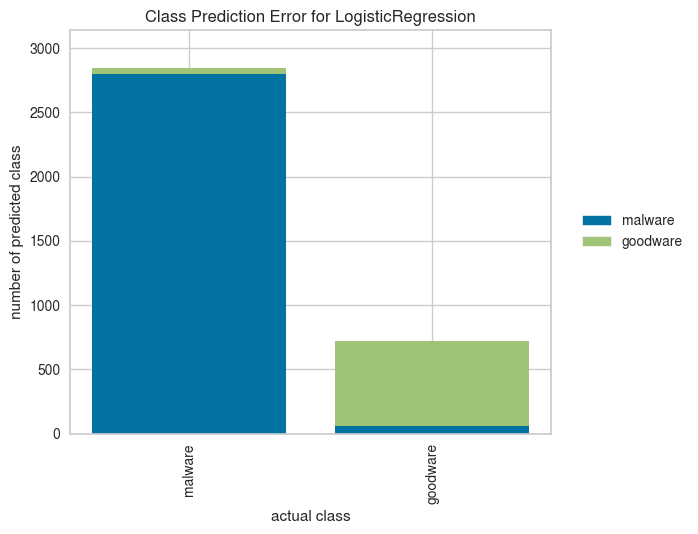

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


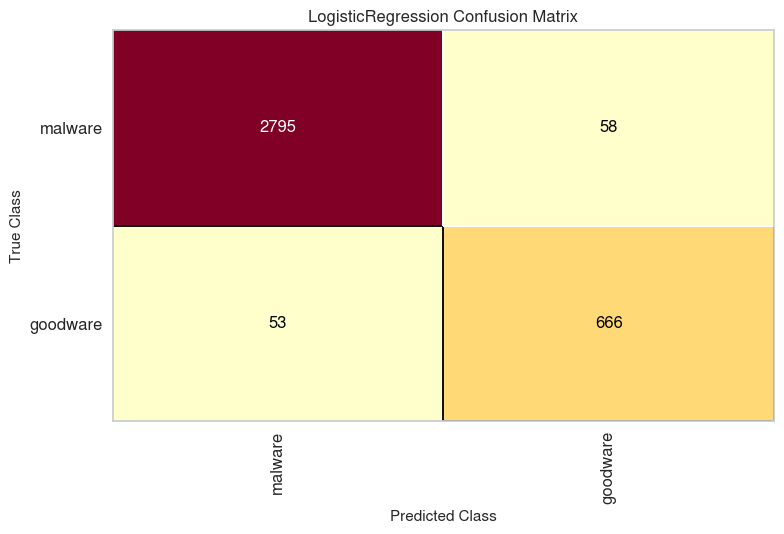

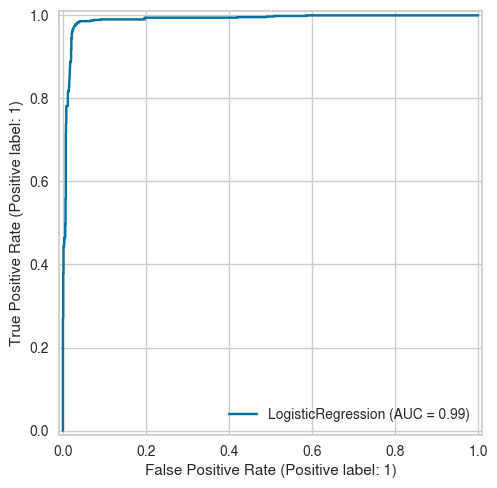

 Training time: 125ms
 F1 Score: 0.9689249720044792
 MCC Score: 0.9036154657063671


In [928]:
# lists to record time and scores
f1scores = []
mccscores = []
times = []

time, f1score, mccscore = evaluate(train_df = X_train, test_df = X_test, train_target=y_train, test_target=y_test)
print(f' Training time: {time}ms\n F1 Score: {f1score}\n MCC Score: {mccscore}')
f1scores.append(f1score)
mccscores.append(mccscore)
times.append(time)

Quindi abbiamo che nonostante ci siamo molte features, riusciamo comunque a valture tutto il dataset in tempi accettabili. Questo ci piace anche se siamo a conoscenza del fatto che dovessimo avere più istanze nel nostro dataset il tempo di predizione non scalerebbe per niente bene. Siccome noi però non dobbiamo fare altro che creare un modello giocattolo per vedere se eliminando alcune feature dal dataset riusciamo a mantenere lo f1-score questa cosa ci va bene.

## Preparazione dei dati

Prima di creare test e train set di decide di fare una fase di preparazione dei dati. 

Si è già dimostrato che per quanto sbilanciato il dataset è molto pulito, quindi non ci sarà bisogno di svolgere molti goodwareaggi in questa sezione

Now, we can remove columns with very low variance; which are the ones that have almost constant values in every row. we can use the estimator with a low threshold like 0. a variance of 0 means that corresponding column only contains a constant value, which is the same for each row. in other words, it's useless.

In [929]:
# Per la prima operazione di selezione delle feature partiamo dall'avere tutte le feature come feature più importanti
most_important_features = uni_feature

### Analisi bivariata della correlazione - Eliminazione feature ridondanti

Il coefficiente di correlazione ha valori compresi tra -1 e 1
- Un valore più vicino allo 0 implica una correlazione più debole (0 esatto implica nessuna correlazione)
- Un valore più vicino a 1 implica una correlazione positiva più forte
- Un valore più vicino a -1 implica una correlazione negativa più forte

Se due features indipendenti (indipendenti = non target) hanno una correlazione assoluta elevata, le informazioni che offrono per il nostro modello ML sono sostanzialmente le stesse.

Le funzionalità correlate in generale non migliorano i modelli, quindi se ne può eliminarne una, in quanto è ridondante. Con la seguente funzione possiamo selezionare fature altamente correlate (correlate ad un altra feature al 95%)

In [930]:
# nota: la funzione rimuoverà la PRIMA feature correlata a qualsiasi altra feature
def correlation(dataset, threshold):
    col_corr = set() 
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # siamo interessati al valore assoluto del coeff
                colname = corr_matrix.columns[i]  # si prende la stringa del nome della colonna
                col_corr.add(colname)
    return col_corr

**Nota**: calcoliamo prima la divisione in train e test set perchè volgiamo applicare il metodo di eliminazione delle feature ridondanti appena definito solo sul train set per poi verificare produca buoni risulati anche sul test set. Se si andasse immediatamente ad abbplicare direttamente su tutto il dataset si causerebbe overfitting

In [931]:
X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.80, random_state=42, stratify=uni_target)

In [932]:
non_correlated_features = correlation(X_train, 0.95) #da qui si imposta che voglio threshold di correlazione minimo 95%
# Ossia tutte le feature che sono correlate ad un altra feature per almeno il 95% vengono eliminate

# Inizializzo variabile delle feature meno importanti
less_important_features = non_correlated_features

# Aggiornamento delle variabili di test e trai dopo aver calcolato le feature da droppare
X_train = X_train.drop(non_correlated_features, axis=1)
X_test = X_test.drop(non_correlated_features, axis=1)

n_correlated_features = X_train.shape[1]

print(f'Dopo aver droppato {len(non_correlated_features)} features, rimangono {n_correlated_features} features.')
print("Features droppate:")
print(non_correlated_features)

Dopo aver droppato 75 features, rimangono 166 features.
Features droppate:
{'BROADCAST_SMS', 'READ_SOCIAL_STREAM', 'WRITE_SYNC_SETTINGS', 'READ_HISTORY_BOOKMARKS', 'REORDER_TASKS', 'SET_DEBUG_APP', 'BIND_APPWIDGET', 'BIND_REMOTEVIEWS', 'MEDIA_CONTENT_CONTROL', 'DIAGgoodwareSTIC', 'BIND_VOICE_INTERACTION', 'SET_PROCESS_LIMIT', 'FORCE_BACK', 'SET_TIME_ZONE', 'SUBSCRIBED_FEEDS_READ', 'DEVICE_POWER', 'CAPTURE_VIDEO_OUTPUT', 'WRITE_HISTORY_BOOKMARKS', 'BIND_goodwareTIFICATION_LISTENER_SERVICE', 'WRITE_PROFILE', 'CALL_PRIVILEGED', 'BRICK', 'SET_PREFERRED_APPLICATIONS', 'SIGNAL_PERSISTENT_PROCESSES', 'UNINSTALL_SHORTCUT', 'ACCESS_SURFACE_FLINGER', 'BIND_TEXT_SERVICE', 'UPDATE_DEVICE_STATS', 'SET_POINTER_SPEED', 'SEND_RESPOND_VIA_MESSAGE', 'SET_TIME', 'BIND_INPUT_METHOD', 'BIND_VPN_SERVICE', 'INJECT_EVENTS', 'READ_FRAME_BUFFER', 'WRITE_SOCIAL_STREAM', 'CHANGE_COMPONENT_ENABLED_STATE', 'WRITE_VOICEMAIL', 'PERSISTENT_ACTIVITY', 'MANAGE_APP_TOKENS', 'GLOBAL_SEARCH', 'DELETE_CACHE_FILES', 'SET_ALA

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


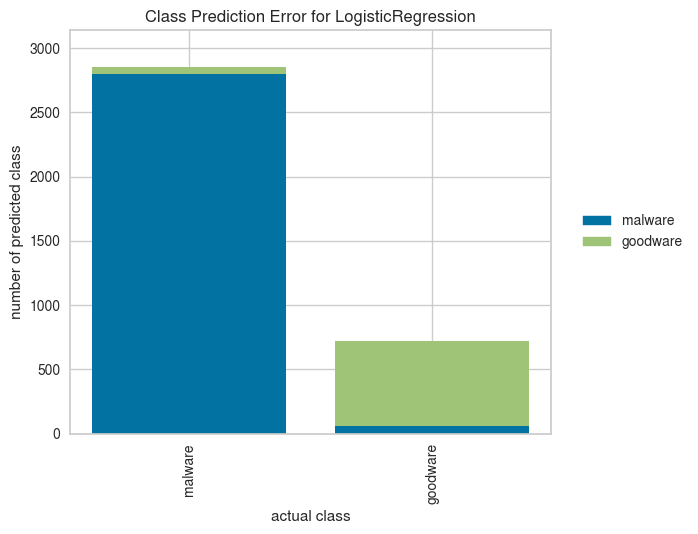

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


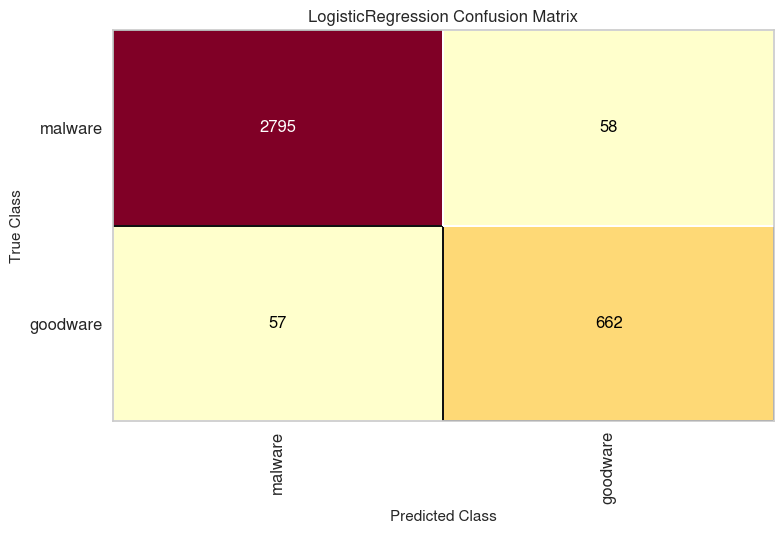

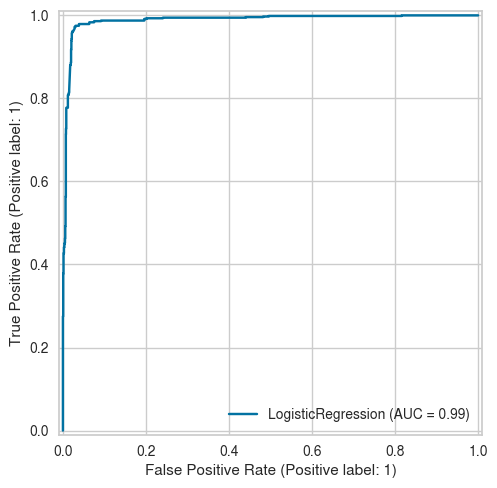

 Training time: 61ms
 F1 Score: 0.9678051511758119
 MCC Score: 0.899925987822791


In [933]:
# lists to record time and scores
f1scores = []
mccscores = []
times = []

time, f1score, mccscore = evaluate(train_df = X_train, test_df = X_test, train_target=y_train, test_target=y_test)
print(f' Training time: {time}ms\n F1 Score: {f1score}\n MCC Score: {mccscore}')
f1scores.append(f1score)
mccscores.append(mccscore)
times.append(time)

Dato che abbiamo appurato che la funzione da buoni risultati possiamo aggironare quindi la variabile delle dataset contente solo le fature più importanti come segue:

In [934]:
# Inizializzazione varibile feature più importanti
most_important_features = most_important_features.drop(non_correlated_features, axis=1)

### Analisi bivariata della correlazione - Highlight delle feature più importanti

A differenza della correlazione a coppie vista prima, in cui è desiderabile una correlazione bassa tra due feature diverse, in questo caso vorremmo che le nostre features avessero un'elevata correlazione con il target. Se una feature ha una bassa correlazione con il target, significa che non è una funzionalità utile per prevedere il target e, pertanto, dovrebbe essere rimossa. 

La seguente funzione calcolerà la correlazione di ciascuna feature con il target e poi restituirà le colonne che hanno una correlazione inferiore alla soglia scelta.

In [935]:
def corrwith_target(dataframe, target, threshold):
    cor = dataframe.corr()
    # Calcolo Correlazione con il target
    cor_target = abs(cor[target])
    # Seleziona le features non correlate
    # se non supera la soglia 'threshold' goodwareata come parametro si aggiunge la colonna all'elelenco di colonne da scartare
    relevant_features = cor_target[cor_target<threshold]
    return relevant_features.index.tolist()[:-1]

In [936]:
X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.80, random_state=42, stratify=uni_target)

In [937]:
# Si deve creare una variabile di test-set dummy (che contiene anche il target) per far girare il metodo appena creato
dummy_train = X_train.copy()
dummy_train['Label'] = y_train

In [938]:
#facciamo rimanere le colonne che hanno correlazione con il target superiore a 5%
corrwith_cols = corrwith_target(dummy_train, 'Label', 0.05)

# Aggiunta delle feature meno importanti ritrovate a questo passaggio
less_important_features.update( corrwith_cols )

# Aggiornamento delle feature più importanti 
# (si droppano quelle meno importanti appena trovate da quelle most_important trovate precedentemente)
# Crea un set di nomi delle colonne più importanti
most_important_features_columns = set(most_important_features.columns)
# Trova l'intersezione tra most_important_features - corrwith_cols
common_columns = most_important_features_columns.intersection(corrwith_cols)

# Droppa le colonne da most_important_features se ce ne sono
if common_columns:
    X_train.drop(columns=common_columns, inplace=True)
    X_test.drop(columns=common_columns, inplace=True)

n_correlated_features = X_train.shape[1]

print(f'Dopo aver droppato in totale {len(less_important_features)} features, rimangono {n_correlated_features} features.')
print("Colonne droppate in questa operazione:")
print(corrwith_cols)

Dopo aver droppato in totale 108 features, rimangono 133 features.
Colonne droppate in questa operazione:
['ACCESS_CHECKIN_PROPERTIES', 'ACCESS_COARSE_UPDATES', 'ACCESS_LOCATION_EXTRA_COMMANDS', 'ACCESS_MOCK_LOCATION', 'ACCESS_SUPERUSER', 'ACCOUNT_MANAGER', 'BATTERY_STATS', 'BIND_ACCESSIBILITY_SERVICE', 'BODY_SENSORS', 'BROADCAST_STICKY', 'CHANGE_CONFIGURATION', 'CHANGE_WIFI_MULTICAST_STATE', 'CLEAR_APP_CACHE', 'CLEAR_APP_USER_DATA', 'DUMP', 'EXPAND_STATUS_BAR', 'FACTORY_TEST', 'INSTALL_LOCATION_PROVIDER', 'MASTER_CLEAR', 'MODIFY_PHONE_STATE', 'MOUNT_FORMAT_FILESYSTEMS', 'NFC', 'PROCESS_OUTGOING_CALLS', 'READ_CALL_LOG', 'READ_CONTACTS', 'READ_EXTERNAL_STORAGE', 'READ_PROFILE', 'READ_SYNC_STATS', 'READ_USER_DICTIONARY', 'SET_ACTIVITY_WATCHER', 'SET_WALLPAPER_HINTS', 'WRITE_SETTINGS', 'Ljava/lang/Runtime;->exec']


/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


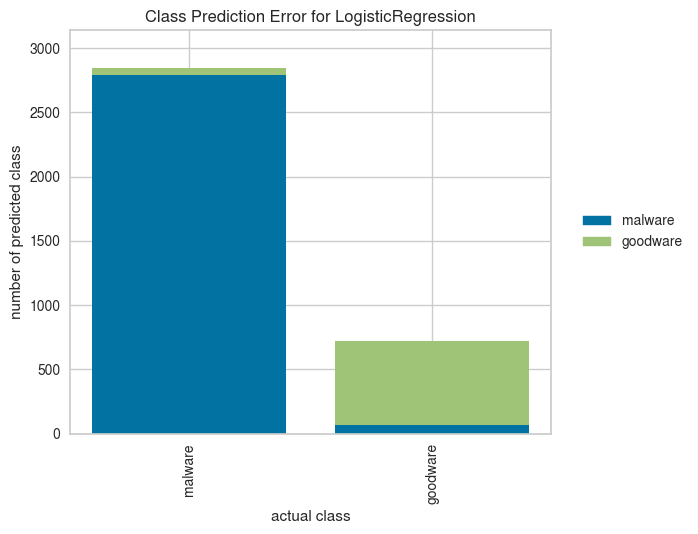

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


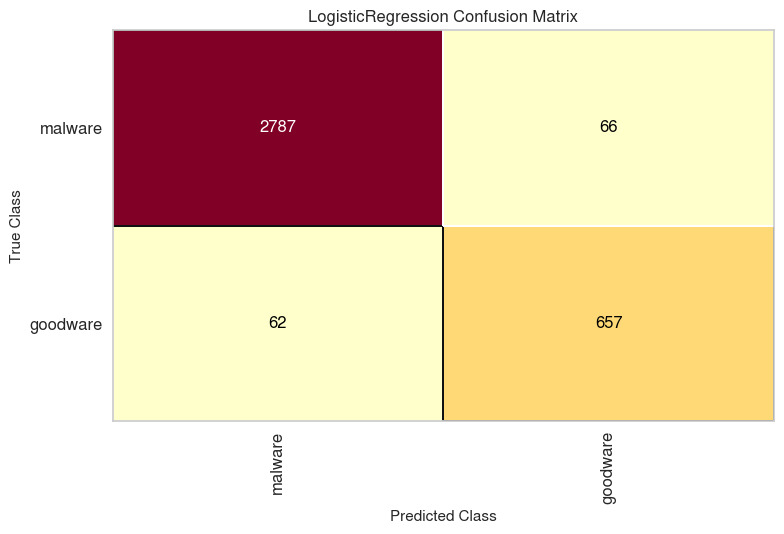

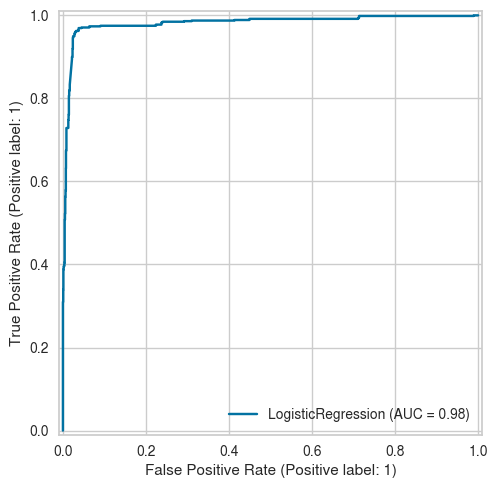

 Training time: 45ms
 F1 Score: 0.9641657334826428
 MCC Score: 0.8887917170098716


In [939]:
# lists to record time and scores
f1scores = []
mccscores = []
times = []

time, f1score, mccscore = evaluate(train_df = X_train, test_df = X_test, train_target=y_train, test_target=y_test)
print(f' Training time: {time}ms\n F1 Score: {f1score}\n MCC Score: {mccscore}')
f1scores.append(f1score)
mccscores.append(mccscore)
times.append(time)

In [940]:
# Dopo aver dimostrato il funzionamento possiamo droppare le colonne da most_important_features (che ricordiamo è una variabile contiene le istanze)
if common_columns:
    most_important_features.drop(columns=common_columns, inplace=True)

### RFE-CV (Recursive feature elimination)

So che è una cosa buona e che rimuove le features ma non so bene come funziona

In [941]:
X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.80, random_state=42, stratify=uni_target)

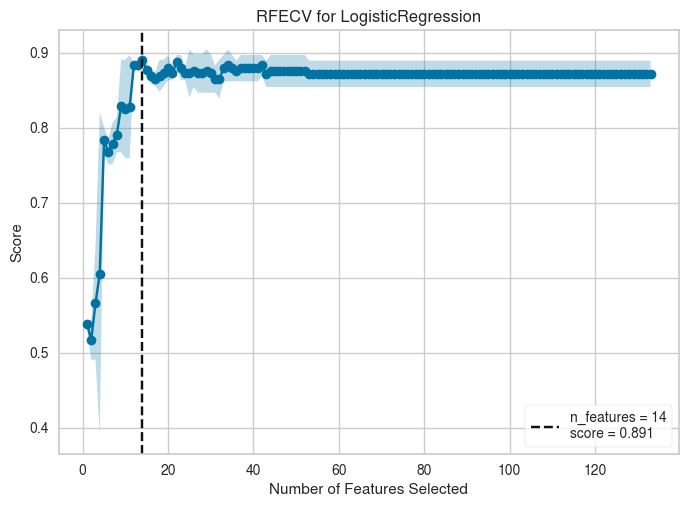

<Axes: title={'center': 'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [942]:
# Visualize the data
mcc_scorer = make_scorer(matthews_corrcoef)
rfecv = RFECV(estimator=LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear'),
              cv=StratifiedKFold(2),
              scoring =  mcc_scorer)
rfecv.fit(X_train, y_train.values.ravel())
rfecv.show() 

In [943]:
mask = rfecv.get_support()

#variabile tmp per avere tutte le colonne
columns = X_train.columns

#variabile con colonne selezionate / non selezionate da RFE 
# Aggiunta delle feature meno importanti ritrovate a questo passaggio
less_important_features.update( columns[~mask] ) 
most_important_features_columns = columns[mask]

# Aggiornamento delle variabili di test e trai dopo aver calcolato le feature da droppare
X_train = pd.DataFrame(rfecv.transform(X_train), columns = most_important_features_columns)
X_test = pd.DataFrame(rfecv.transform(X_test), columns = most_important_features_columns)

print(f'Dopo aver droppato in totale {len(less_important_features)} features, rimangono {X_train.shape[1]} features.')
print("Colonne droppate in questa operazione:")
print(less_important_features)

Dopo aver droppato in totale 227 features, rimangono 14 features.
Colonne droppate in questa operazione:
{'READ_EXTERNAL_STORAGE', 'BROADCAST_SMS', 'REORDER_TASKS', 'RECEIVE_USER_PRESENT', 'VIBRATE', 'Landroid/telephony/TelephonyManager;->getLine1Number', 'GET_PACKAGE_SIZE', 'ADD_VOICEMAIL', 'Lcom/google/android/gms/location/LocationClient;->getLastLocation', 'USES_POLICY_FORCE_LOCK', 'BIND_ACCESSIBILITY_SERVICE', 'Landroid/location/LocationManager;->getLastKgoodwarewnLocation', 'SUBSCRIBED_FEEDS_READ', 'SEND', 'RECEIVE', 'PROCESS_OUTGOING_CALLS', 'UPDATE_DEVICE_STATS', 'REBOOT', 'SET_TIME', 'ACCESS_SUPERUSER', 'BIND_INPUT_METHOD', 'READ_FRAME_BUFFER', 'ACCESS_MTK_MMHW', 'READ_AVESTTINGS', 'RESPOND', 'WRITE_SETTINGS', 'WRITE_MEDIA_STORAGE', 'MANAGE_APP_TOKENS', 'BIND_DEVICE_ADMIN', 'GLOBAL_SEARCH', 'USE_FINGERPRINT', 'SET_ORIENTATION', 'READ_VOICEMAIL', 'REQUEST', 'READ_CALL_LOG', 'ACCESS_PROVIDER', 'USE_SIP', 'DOWNLOAD_WITHOUT_goodwareTIFICATION', 'ACCESS_MOCK_LOCATION', 'READ_USER_DI

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(
/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


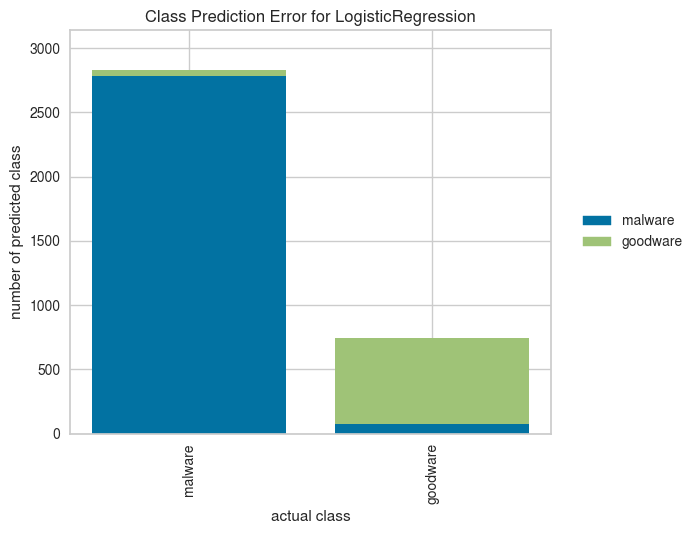

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


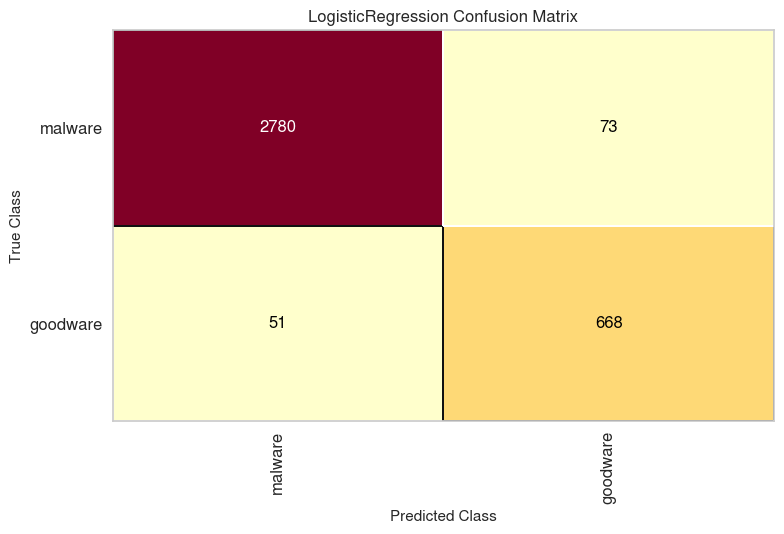

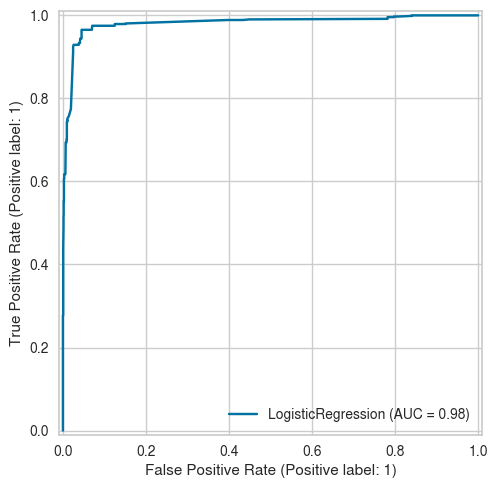

 Training time: 11ms
 F1 Score: 0.9652855543113102
 MCC Score: 0.8934193199508695


In [944]:
# lists to record time and scores
f1scores = []
mccscores = []
times = []

time, f1score, mccscore = evaluate(train_df = X_train, test_df = X_test, train_target=y_train, test_target=y_test)
print(f' Training time: {time}ms\n F1 Score: {f1score}\n MCC Score: {mccscore}')
f1scores.append(f1score)
mccscores.append(mccscore)
times.append(time)

In [945]:
# Dopo che abbiamo appurato che produce buoni risultati possiamo aggiornare il dataset contenente solo le feature più importanti
most_important_features = most_important_features[most_important_features_columns]

## PCA

In [946]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [947]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(most_important_features)

scaled_data

array([[-0.24201745, -0.22051257, -0.16691592, ..., -0.46798078,
        -0.28941008, -0.31758957],
       [-0.24201745, -0.22051257, -0.16691592, ..., -0.46798078,
        -0.28941008,  3.14871806],
       [-0.24201745, -0.22051257, -0.16691592, ..., -0.46798078,
        -0.28941008, -0.31758957],
       ...,
       [-0.24201745, -0.22051257, -0.16691592, ..., -0.46798078,
        -0.28941008, -0.31758957],
       [-0.24201745, -0.22051257, -0.16691592, ...,  2.13683991,
        -0.28941008, -0.31758957],
       [-0.24201745, -0.22051257, -0.16691592, ...,  2.13683991,
        -0.28941008, -0.31758957]])

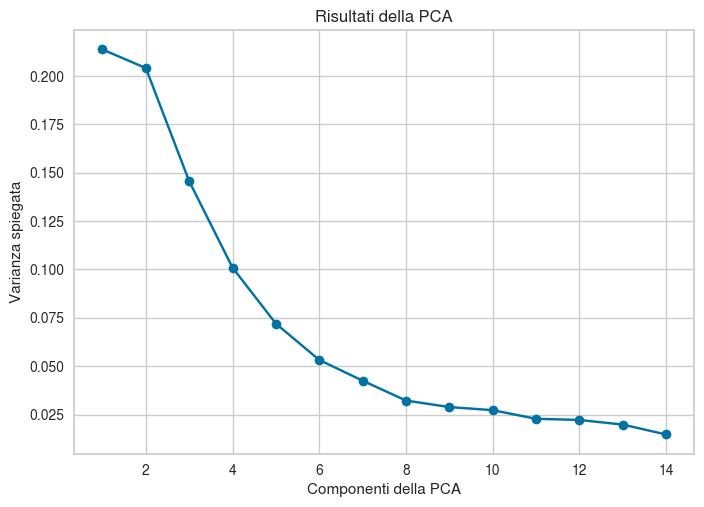

In [948]:
pca = PCA().fit(scaled_data)

# Crea un grafico della varianza spiegata per ogni componente
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")
plt.show()

La varianza spiegata rappresenta la quantità di variazione nei dati originariamente presenti nei dati e catturati da ciascuna componente principale. 

Vogliamo cercare di trovare il numero minimo di componenti principali che spieghino una quantità significativa della varianza nei dati. Questo può essere determinato osservando il grafico della varianza spiegata e cercando il "gomito" nella curva, dove l'aggiunta di ulteriori componenti principali non contribuisce significativamente a spiegare la varianza.

Potremmo ora noi scegliere di mostrare solo tra i primi 30 e 50 risultati

In [949]:
# Applica la PCA per ridurre la dimensionalità dei dati
pca = PCA(n_components=10).fit(scaled_data)
pca_data = pca.transform(scaled_data)

In [950]:
# Quantifichiamo  la percentuale di varianza spiegata da ciascuno delle componenti.
print(pca.explained_variance_ratio_)

[0.21371012 0.20410943 0.14563145 0.10092941 0.07200375 0.05321893
 0.04250508 0.03224931 0.02886486 0.02725967]


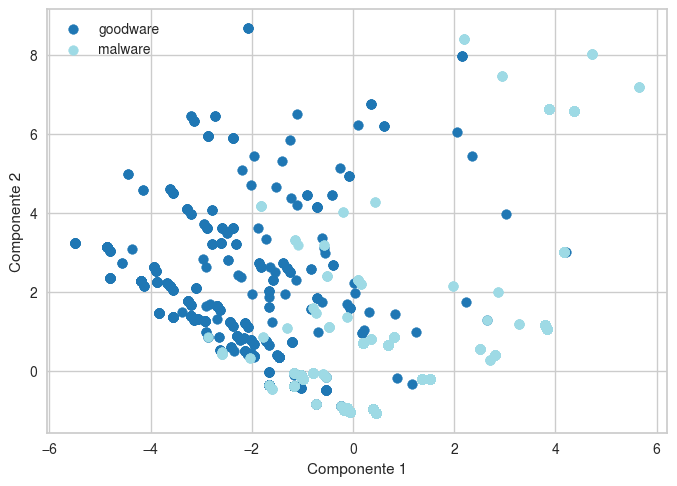

In [951]:
# crea una mappa etichetta-->codice colore
unique_labels = np.unique(dataset["Label"])
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
label_to_color = dict(zip(unique_labels, colors))

# genera il grafico
fig, ax = plt.subplots()
for label in unique_labels:
    mask = (dataset["Label"] == label).values
    ax.scatter(pca_data[mask, 0], pca_data[mask, 1], color=label_to_color[label], label=label)

ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')

ax.legend()

plt.show()

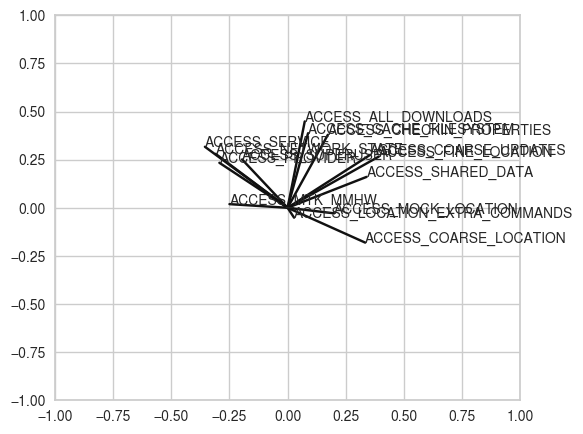

In [952]:
pcs = pca.components_
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # plot line between origin and point (x, y)
    ax.plot([0, x], [0, y], color='k')
    # display the label of the point
    ax.text(x, y, dataset.columns[i], fontsize='10')

## Creazione di Test e Train set

In [953]:
#prima sostituisco nel target dei valori numerici 0 ed 1 alle stringhe "goodware" e "malware"
uni_target = uni_target.replace(to_replace=["goodware", "malware"], value=[1, 0])
print(uni_target)

X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.80, random_state=42, stratify=uni_target)

      Label
0         0
1         0
2         0
3         0
4         0
...     ...
4460      1
4461      1
4462      1
4463      1
4464      1

[4464 rows x 1 columns]


In [954]:
y_train = y_train.replace(to_replace=["goodware", "malware"], value=[1, 0])
y_test = y_test.replace(to_replace=["goodware", "malware"], value=[1, 0])

### Rimuovere colonne con varianza 0

This technique eliminates features that have a variation below a specified threshold. When a characteristic doesn't vary much within itself, it has low predictive potential, according to the theory.

In order to use this technique, it's better if we first normalize our data using scikit learn's `Normalizer`. the difference between `normalizer` and `standardScaler` is that Normalizer does not remove the mean and scale by deviation but scales the whole row to unit norm. Ma noi abbiamo già che tutto il dataset è normalizzato quindi non ci  interessa fare questo step 

**yet another time, to reduce test data leakage, I'm fitting scaler on training data and then transform both train and test sets.**

In [955]:
selector = VarianceThreshold()
selector.fit(X_train)

VarianceThreshold()

In [956]:
mask = selector.get_support()
columns = X_train.columns

# Aggiornamento delle feature più importanti 
# (si droppano quelle meno importanti appena trovate da quelle most_important trovate precedentemente)
# Crea un set di nomi delle colonne più importanti
least_important_features_columns = columns[mask]
most_important_features = uni_feature
# Droppa le colonne da most_important_features se ce ne sono
if len(least_important_features_columns)>0:
    most_important_features.drop(columns=least_important_features_columns, inplace=True)

n_features2 = len(most_important_features)
print(f'Dopo aver droppato { len(least_important_features_columns) } features, rimangono {most_important_features.shape[1]} features.')

Dopo aver droppato 14 features, rimangono 227 features.


In [957]:
most_important_features

,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/content/pm/PackageManager;->getInstalledApplications,Landroid/content/pm/PackageManager;->getInstalledPackages,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4460,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


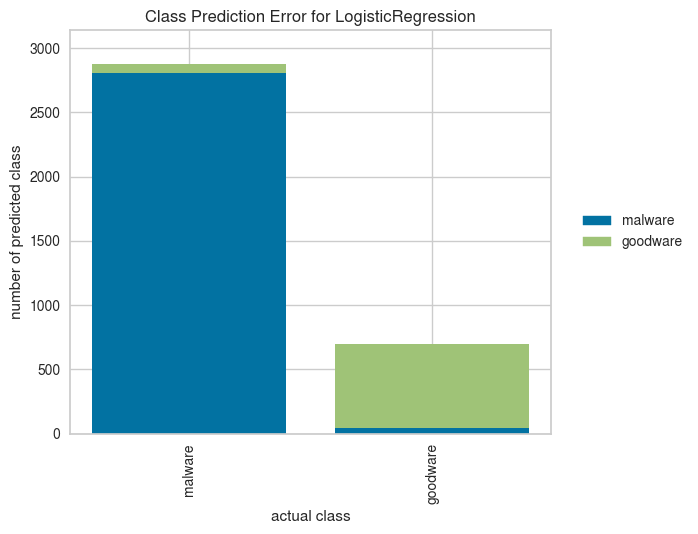

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


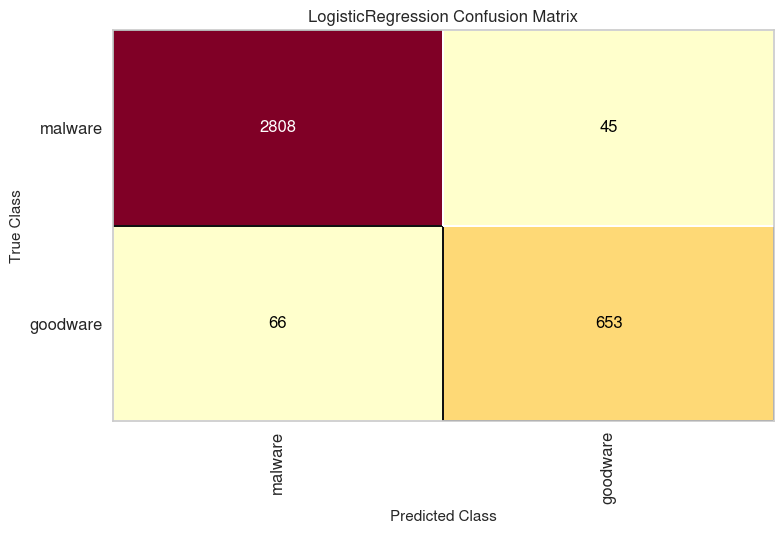

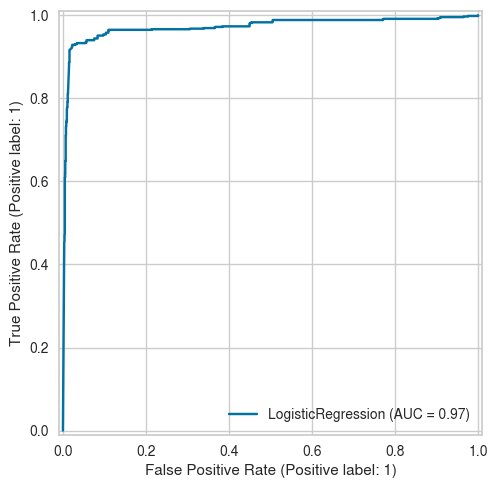

 Training time: 221ms
 F1 Score: 0.9689249720044792
 MCC Score: 0.9024431331277278


In [958]:
X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.80, random_state=42, stratify=uni_target)

# lists to record time and scores
f1scores = []
mccscores = []
times = []

time, f1score, mccscore = evaluate(train_df = X_train, test_df = X_test, train_target=y_train, test_target=y_test)
print(f' Training time: {time}ms\n F1 Score: {f1score}\n MCC Score: {mccscore}')
f1scores.append(f1score)
mccscores.append(mccscore)
times.append(time)